# Explaining Autopilot Models

Kernel `Python 3 (Data Science)` works well with this notebook.

_This notebook was created and tested on an ml.m5.xlarge notebook instance._

## Table of Contents

1. [Introduction](#introduction)
3. [Setup](#setup)
4. [Local explanation with KernelExplainer](#Local)
5. [KernelExplainer computation cost](#cost) 
6. [Global explanation with KernelExplainer](#global)
7. [Conclusion](#conclusion)


---
## Introduction<a name="introduction"></a>
Machine learning (ML) models have long been considered black boxes since predictions from these models are hard to interpret. While decision trees can be interpreted by observing the parameters learned by the models, it is generally difficult to get a clear picture.

Model interpretation can be divided into local and global explanations. A local explanation considers a single sample and answers questions like: "why the model predicts that customer A will stop using the product?" or "why the ML system refused John Doe a loan?". Another interesting question is "what should John Doe change in order to get the loan approved?". On the contrary, global explanations aim at explaining the model itself and answer questions like "which features are important for prediction?". It is important to note that local explanations can be used to derive global explanations by averaging many samples. For further reading on interpretable ML, see the excellent book by [Christoph Molnar](https://christophm.github.io/interpretable-ml-book).

In this blog post, we will demonstrate the use of the popular model interpretation framework [SHAP](https://github.com/slundberg/shap) for both local and global interpretation.

### SHAP

[SHAP](https://github.com/slundberg/shap) is a game theoretic framework inspired by [Shapley Values](https://www.rand.org/pubs/papers/P0295.html) that provides local explanations for any model. SHAP has gained popularity in recent years, probably due to its strong theoretical basis. The SHAP package contains several algorithms that, given a sample and a model, derive the SHAP value for each of the model's input features. The SHAP value of a feature represents the feature's contribution to the model's prediction.

To explain models built by [Amazon SageMaker Autopilot](https://aws.amazon.com/sagemaker/autopilot/) we use SHAP's `KernelExplainer` which is a black box explainer. `KernelExplainer` is robust and can explain any model, thus can handle Autopilot's complex feature processing. `KernelExplainer` only requires that the model will support an inference functionality which, given a sample, will return the model's prediction for that sample. The prediction being the predicted value for regression and the class probability for classification.

It is worth noting that SHAP includes several other explainers such as `TreeExplainer` and `DeepExplainer` that are specific for decision forest and neural networks respectively. These are not black box explainers and require knowledge of the model structure and trained params. `TreeExplainer` and `DeepExplainer` are limited and currently can not support any feature processing.

---
## Setup<a name="setup"></a>
In this notebook we will start with a model built by SageMaker Autopilot which was already trained on a binary classification task. Please refer to this [notebook](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/autopilot/autopilot_customer_churn.ipynb) to see how to create and train an Autopilot model. 

In [42]:
import boto3
import pandas as pd
import sagemaker
from sagemaker import AutoML
from datetime import datetime
import numpy as np

region = boto3.Session().region_name
session = sagemaker.Session()

Install SHAP (it may take a while to resolve conda dependencies)

In [43]:
!conda install -c conda-forge -y shap

Solving environment: | 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - defaults/linux-64::pandas==1.0.1=py36h0573a6f_0
  - defaults/linux-64::scikit-learn==0.22.1=py36hd81dba3_0
  - defaults/linux-64::bkcharts==0.2=py36_0
  - defaults/linux-64::pytest-arraydiff==0.3=py36h39e3cac_0
  - defaults/linux-64::bottleneck==1.3.2=py36heb32a55_0
  - defaults/linux-64::pywavelets==1.1.1=py36h7b6447c_0
  - defaults/noarch::pytest-astropy==0.8.0=py_0
  - defaults/linux-64::numexpr==2.7.1=py36h423224d_0
  - defaults/linux-64::h5py==2.10.0=py36h7918eee_0
  - defaults/linux-64::bokeh==1.4.0=py36_0
  - defaults/linux-64::numpy-base==1.18.1=py36hde5b4d6_1
  - conda-forge/linux-64::shap==0.36.0=py36h7c3b610_0
  - defaults/linux-64::astropy==4.0=py36h7b6447c_0
  - defaults/linux-64::patsy==0.5.1=py36_0
  - defaults/linux-64::scikit-image==0.16.2=py36h0573a6f_0
  - defaults/linux-64::matplotlib-base==3.1.3=py36hef1b27d_0
 

In [44]:
import shap

from shap import KernelExplainer
from shap import sample
from scipy.special import expit

# Initialize plugin to make plots interactive.
shap.initjs()

### Create an inference endpoint<a name="Endpoint"></a>
Creating an inference endpoint for the trained Autopilot model. Skip this step if an endpoint with the argument `inference_response_keys` set as
`['predicted_label', 'probability']` was already created.

In [45]:
#automl_job_name = '<your_automl_job_name_here>'
#retrieving automl_job_name from previously run AutoML notebook
%store -r
auto_ml_job_name
automl_job_name = auto_ml_job_name
print(automl_job_name)
automl_job = AutoML.attach(automl_job_name, sagemaker_session=session)

# Endpoint name
ep_name = 'sagemaker-automl-' + datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
print(ep_name)

sagemaker-automl-2020-12-04-22-52-56


In [46]:
# For classification response to work with SHAP we need the probability scores. This can be achieved by providing a list of keys for
# response content. The order of the keys will dictate the content order in the response. This parameter is not needed for regression.
inference_response_keys = ['predicted_label', 'probability']

# Create the inference endpoint
automl_job.deploy(initial_instance_count=1, instance_type='ml.m5.2xlarge', inference_response_keys=inference_response_keys,
                 endpoint_name=ep_name)

-------------!

### Wrap Autopilot's endpoint with an estimator class.<a name="Endpoint"></a>
For ease of use, we wrap the inference endpoint with a custom estimator class. Two inference functions are provided: `predict` which
returns the numeric prediction value to be used for regression and `predict_proba` which returns the class probability to be used for
classification.

In [47]:
#from sagemaker.predictor import RealTimePredictor
from sagemaker.predictor import Predictor

#from sagemaker.content_types import CONTENT_TYPE_CSV


class AutomlEstimator:
    def __init__(self, endpoint_name, sagemaker_session):
#        self.predictor = RealTimePredictor(
        self.predictor = Predictor(            
            endpoint_name=endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=sagemaker.serializers.CSVSerializer(),
#            content_type=CONTENT_TYPE_CSV,
            content_type="text/csv",
#            accept=CONTENT_TYPE_CSV
            accept="text/csv"
            
        )
    
    def get_automl_response(self, x):
        if x.__class__.__name__ == 'ndarray':
            payload = ""
            for row in x:
                payload = payload + ','.join(map(str, row)) + '\n'
        else:
            payload = x.to_csv(sep=',', header=False, index=False)
        return self.predictor.predict(payload).decode('utf-8')

    # Prediction function for regression
    def predict(self, x):
        response = self.get_automl_response(x)
        # we get the first column from the response array containing the numeric prediction value (or label in case of classification)
        response = np.array([x.split(',')[0] for x in response.split('\n')[:-1]])
        return response

    # Prediction function for classification
    def predict_proba(self, x):
        """Extract and return the probability score from the AutoPilot endpoint response."""
        response = self.get_automl_response(x)
        # we get the second column from the response array containing the class probability
        response = np.array([x.split(',')[1] for x in response.split('\n')[:-1]])
        return response.astype(float)

Create an instance of `AutomlEstimator`

In [48]:
automl_estimator = AutomlEstimator(endpoint_name=ep_name, sagemaker_session=session)

content_type is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
accept is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


### Data
In this notebook we will use the same dataset as used in the [Customer Churn notebook.](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/autopilot/autopilot_customer_churn.ipynb)
Please follow the "Customer Churn" notebook to download the dataset if it was not previously downloaded.

### Background data
KernelExplainer requires a sample of the data to be used as background data. KernelExplainer uses this data to simulate a feature being missing by replacing the feature value with a random value from the background. We use shap.sample to sample 50 rows from the dataset to be used as background data. Using more samples as background data will produce more accurate results but runtime will increase. Choosing background data is challenging, see the whitepapers: https://storage.googleapis.com/cloud-ai-whitepapers/AI%20Explainability%20Whitepaper.pdf  and https://docs.seldon.io/projects/alibi/en/latest/methods/KernelSHAP.html#Runtime-considerations. Note that the clustering algorithms provided in shap only support numeric data. According to SHAP's documentation, a vector of zeros could be used as background data to produce reasonable results.

In [49]:
#churn_data = pd.read_csv('../Data sets/churn.txt')
churn_data = pd.read_csv('../autopilot/Data sets/churn.txt')

data_without_target = churn_data.drop(columns=['Churn?'])

background_data = sample(data_without_target, 50)

### Setup KernelExplainer

Next, we create the `KernelExplainer`. Note that since it's a black box explainer, `KernelExplainer` only requires a handle to the
predict (or predict_proba) function and does not require any other information about the model. For classification it is recommended to
derive feature importance scores in the log-odds space since additivity is a more natural assumption there thus we use `logit`. For
regression `identity` should be used.

In [50]:
# Derive link function 
problem_type = automl_job.describe_auto_ml_job(job_name=automl_job_name)['ResolvedAttributes']['ProblemType'] 
link = "identity" if problem_type == 'Regression' else "logit"

# the handle to predict_proba is passed to KernelExplainer since KernelSHAP requires the class probability
explainer = KernelExplainer(automl_estimator.predict_proba, background_data, link=link)


By analyzing the background data `KernelExplainer` provides us with `explainer.expected_value` which is the model prediction with all features missing. Considering a customer for which we have no data at all (i.e. all features are missing) this should theoretically be the model prediction.

In [51]:
# Since expected_value is given in the log-odds space we convert it back to probability using expit which is the inverse function to logit
print('expected value =', expit(explainer.expected_value))

expected value = 0.21218724478268997


---
## Local explanation with KernelExplainer<a name="local"></a>
We will use `KernelExplainer` to explain the prediction of a single sample, the first sample in the dataset.

In [52]:
# Get the first sample
x = data_without_target.iloc[0:1]

# ManagedEndpoint can optionally auto delete the endpoint after calculating the SHAP values. To enable auto delete, use ManagedEndpoint(ep_name, auto_delete=True)
from managed_endpoint import ManagedEndpoint
with ManagedEndpoint(ep_name) as mep:
    shap_values = explainer.shap_values(x, nsamples='auto', l1_reg='aic')

SHAP package includes many visualization tools. See below a `force_plot` which provides a good visualization for the SHAP values of a single sample

In [53]:
# Since shap_values are provided in the log-odds space, we convert them back to the probability space by using LogitLink
shap.force_plot(explainer.expected_value, shap_values, x, link=link)

From the plot above we learn that the most influential feature is `VMail Message` which pushes the probability down by about 7%. It is
important to note that `VMail Message = 25` makes the probability 7% lower in comparison to the notion of that feature being missing.
SHAP values do not provide the information of how increasing or decreasing `VMail Message` will affect prediction.

In many cases we are interested only in the most influential features. By setting `l1_reg='num_features(5)'`, SHAP will provide non-zero scores for only the most influential 5 features.

In [54]:
with ManagedEndpoint(ep_name) as mep:
    shap_values = explainer.shap_values(x, nsamples='auto', l1_reg='num_features(5)')
shap.force_plot(explainer.expected_value, shap_values, x, link=link)

---
## KernelExplainer computation cost<a name="cost"></a>
KernelExplainer computation cost is dominated by the inference calls. In order to estimate SHAP values for a single sample, KernelExplainer calls the inference function twice: First, with the sample unaugmented. And second, with many randomly augmented instances of the sample. The number of augmented instances in our case is: 50 (#samples in the background data) * 2088 (nsamples = 'auto') = 104,400. So, in our case, the cost of running KernelExplainer for a single sample is roughly the cost of 104,400 inference calls.

---
## Global explanation with KernelExplainer<a name="global"></a>
Next, we will use KernelExplainer to provide insight about the model as a whole. It is done by running KernelExplainer locally on 50 samples and aggregating the results

In [55]:
# Sample 50 random samples
X = sample(data_without_target, 50)

# Calculate SHAP values for these samples, and delete the endpoint
with ManagedEndpoint(ep_name, auto_delete=True) as mep:
    shap_values = explainer.shap_values(X, nsamples='auto', l1_reg='aic')


Deleting the endpoint: sagemaker-automl-2020-12-04-22-52-56


`force_plot` can be used to visualize SHAP values for many samples simultaneously by rotating the plot of each sample by 90 degrees and stacking the plots horizontally. The resulting plot is interactive and can be manually analyzed.

In [56]:
shap.force_plot(explainer.expected_value, shap_values, X, link=link)

`summary_plot` is another visualization tool displaying the mean absolute value of the SHAP values for each feature using a bar plot. Currently, `summary_plot` does not support link functions so the SHAP values are presented in the log-odds space (and not the probability space).

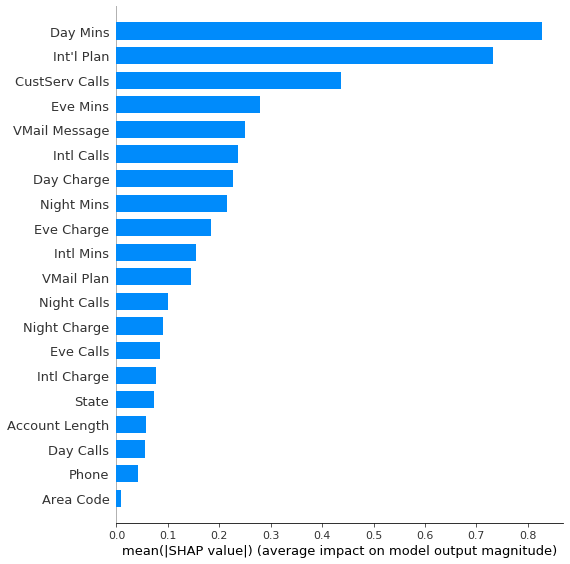

In [57]:
shap.summary_plot(shap_values, X, plot_type="bar")

---
## Conclusion<a name="conclusion"></a>

In this post, we demonstrated how to use KernelSHAP to explain models created by Amazon SageMaker Autopilot both locally and globally. KernelExplainer is a robust black box explainer which requires only that the model will support an inference functionality which, given a sample, returns the model's prediction for that sample. This inference functionality was provided by wrapping Autopilot's inference endpoint with an estimator container.

For more about Amazon SageMaker Autopilot, please see [Amazon SageMaker Autopilot](https://aws.amazon.com/sagemaker/autopilot/).